In [19]:
import mimetypes
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [21]:
class TimeSeries:
    """
    A time-series data visualization class created based on matplotlib. This class provides
    single plot or multiple plots of dataset variables over a time interval. Currenly supports
    marking and annotating minimum/maximum points, and annual peak/trough points, as well as
    zooming-in a specified region of a plot.
    
    Usage:
        ts = TimeSeries(file)
        ts.plot('x', ['y1', 'y2'], start_time='2000', end_time='2010')
    """
    
    def __init__(self, file):
        try:
            self.data = self.read_file(file)
        except FileNotFoundError:
            print('This file does not exist, please check the file name.')
        else:
            # keyword arguments
            self.conf = {
                'title': None, 'title_size': 16,
                'xlabel': None, 'ylabel': [],
                'xlabel_size': 15, 'ylabel_size': 15,
                'xtick_rotate': 0, 'xtick_size': 10,
                'ytick_rotate': 0, 'ytick_size': 10,
                'ylim_bot': None, 'ylim_top': None,
                'my_font': 'DejaVu Sans',
                'legend': [],
                'color': [],
                'backgrid': True,
                'grid_width': 0.5,
                'grid_alpha': 0.5,
                'figsize': (6, 4),
                'show_min': False,
                'show_max': False,
                'min_annotate': False,
                'max_annotate': False,
                'precision': 1,
                'min_size': 15, 'max_size': 15,
                'min_marker': 'v', 'max_marker': '^',
                'min_color': 'red', 'max_color': 'green',
                'show_peaks': False, 
                'show_troughs': False,
                'peak_annotate': False,
                'trough_annotate': False,
                'peak_size': 10, 'trough_size': 10,
                'peak_color': 'green',
                'trough_color': 'red',
                'peak_label': 'Annual Peaks',
                'trough_label': 'Annual Troughs',
                'peak_marker': '^',
                'trough_marker': 'v',
                'zoom_in': False,
                'x_start': [], 'x_end': [],
                'y_start': [], 'y_end': [],
                'zoom_scale': 3,
                'zoom_x_rotate': 90,
                'zoom_loc': 'upper right',
                'multiple_plot': False,
                'date_fmt': None,
                'save_fig': False,
                'fig_path': None,
            }
    
    def read_file(self, file):
        """Read csv, excel, text format file
        Args:
            file: the input dataset
            
        Returns:
            The data read from the file  
        """
        ftype = mimetypes.guess_type(file, strict=True)[0]
        if ftype is None:
            print('Cannot guess file type!')
            return None
        # read csv format data
        if 'excel' in ftype:
            data = pd.read_csv(file)
        # read excel format data
        elif 'sheet' in ftype:
            data = pd.read_excel(file)
        # read text format data
        elif ftype == 'text/plain':
            data = pd.read_csv(file)
        else:
            data = None
            print("File type cannot find!")
        return data
    
    def plot(self, x_col_name, y_col_name, start_time=None, end_time=None, **kwargs):
        """show one or more variables over a period of time
        Args:
            x_col_name: name of the date variable
            y_col_name: list of names for y variable
            start_time: the start date on the timeline
            end_time: the end date on the timeline
            kwargs: a dictionary of optional parameters
            
        Returns:
            None
        """
        
        # when new self.configuraton is set, update the original one
        self.conf.update(kwargs)

        # convert dates to pandas datetime format
        self.data[x_col_name] = pd.to_datetime(self.data[x_col_name])
        
        # extract data from selected time interval
        start_t = (pd.to_datetime(start_time) if start_time
                   else self.data[x_col_name].min())
        end_t = (pd.to_datetime(end_time) if end_time
                else self.data[x_col_name].max())
        data = self.data.loc[(self.data[x_col_name] >= start_t) &
                             (self.data[x_col_name] <= end_t)] 
        data = data.set_index(x_col_name)
        
        # initialize color
        if len(self.conf['color']) == 0:
            self.conf['color'] = sns.color_palette('muted')
        
        if self.conf['multiple_plot']:
            fig, axs = plt.subplots(len(y_col_name), 1, sharex=True,
                            figsize=self.conf['figsize'])
        else:
            fig, ax = plt.subplots(1, 1, figsize=self.conf['figsize'])
            axs = [ax for i in y_col_name]
        
        # plot xy points
        x = data.index
        for i, y_col in enumerate(y_col_name):
            y = data[y_col].values
            color = self.conf['color'][i] if i <= len(self.conf['color'])-1 else 'red'
            label = self.conf['legend'][i] if i <= len(self.conf['legend'])-1 else None
            axs[i].plot(x, y, color=color, label=label)
            if label is not None:
                axs[i].legend()

        # background grid setting
        if self.conf['backgrid']:
            for i, _ in enumerate(y_col_name):
                axs[i].grid(linestyle="--", linewidth=self.conf['grid_width'],
                        color='gray', alpha=self.conf['grid_alpha'])
            
        # set title and size
        axs[0].set_title(self.conf['title'], fontproperties=self.conf['my_font'],
                         fontsize=self.conf['title_size'])

        # set xy labels and size
        axs[-1].set_xlabel(self.conf['xlabel'], fontproperties=self.conf['my_font'],
                           fontsize=self.conf['xlabel_size'])
        for i, _ in enumerate(y_col_name):
            ylabel = self.conf['ylabel'][i] if i <= len(self.conf['ylabel'])-1 else None
            axs[i].set_ylabel(ylabel, fontproperties=self.conf['my_font'],
                              fontsize=self.conf['ylabel_size'])
            if not self.conf['multiple_plot']: break

        # set xy limits (only allowed for single plot)
        if not self.conf['multiple_plot']:
            hi = [max(data[y_col_name[j]]) for j in range(len(y_col_name))]
            lo = [min(data[y_col_name[j]]) for j in range(len(y_col_name))]
            ylim_bot = (min(lo)-max(hi)*0.1 if self.conf['ylim_bot'] is None
                        else self.conf['ylim_bot'])
            ylim_top = (max(hi)*1.1 if self.conf['ylim_top'] is None
                        else self.conf['ylim_top'])
            axs[0].set_ylim(bottom=ylim_bot, top=ylim_top)
        
        # tick labels and size, rotatation
        plt.xticks(ticks=data.index, labels=data.index,
                rotation=self.conf['xtick_rotate'], fontsize=self.conf['xtick_size'])
        plt.yticks(rotation=self.conf['ytick_rotate'], fontsize=self.conf['ytick_size'])
        
        # show dates in "year-month-day" format on x axis
        xlocator = mdates.AutoDateLocator()
        xformatter = mdates.AutoDateFormatter(xlocator)
        axs[0].xaxis.set_major_locator(xlocator)
        axs[0].xaxis.set_major_formatter(xformatter)
        
        if self.conf['show_max']:
            offset = max(max(data[c]) for c in y_col_name)*0.02
            for i, y_col in enumerate(y_col_name):
                y = data[y_col].values
                argmax = np.argmax(y)
                # plot max point
                axs[i].scatter(x[argmax], y[argmax],
                           marker=self.conf['max_marker'],
                           color=self.conf['max_color'])
                if self.conf['max_annotate']:
                    # mark max point
                    y_offset = max(y)*0.02 if self.conf['multiple_plot'] else offset
                    tx = (x[argmax].strftime(self.conf['date_fmt'])
                          if self.conf['date_fmt']
                          else x[argmax].date())
                    ty = y[argmax]
                    show_max = ('[{}, {:.{}e}]'.format(tx, ty, self.conf['precision'])
                               if len(str(ty).split(',')) > 5
                               else '[{}, {:.{}f}]'.format(tx, ty, self.conf['precision']))
                    axs[i].annotate(show_max, xy=(x[argmax],y[argmax]),
                             xytext=(x[argmax], y[argmax]+y_offset),
                             ha="center", va="bottom")
        
        if self.conf['show_min']:
            offset = max(max(data[c]) for c in y_col_name)*0.02
            for i, y_col in enumerate(y_col_name):
                y = data[y_col].values
                argmin = np.argmin(y)
                # plot min point
                axs[i].scatter(x[argmin], y[argmin],
                           marker=self.conf['min_marker'],
                           color=self.conf['min_color'])
                if self.conf['min_annotate']:
                    # mark min point
                    y_offset = max(y)*0.02 if self.conf['multiple_plot'] else offset
                    tx = (x[argmin].strftime(self.conf['date_fmt'])
                          if self.conf['date_fmt']
                          else x[argmin].date())
                    ty = y[argmin]
                    show_min = ('[{}, {:.{}e}]'.format(tx, ty, self.conf['precision'])
                               if len(str(ty).split(',')) > 5
                               else '[{}, {:.{}f}]'.format(tx, ty, self.conf['precision']))
                    axs[i].annotate(show_min, xy=(x[argmin],y[argmin]),
                             xytext=(x[argmin], y[argmin]-y_offset),
                             ha="center", va="top")
        
        if self.conf['show_peaks']:
            for i, y_col in enumerate(y_col_name):
                # identify location of peaks
                y = data[y_col].values
                years = np.unique([str(d.year) for d in data.index]).tolist()
                x_peaks = [data.loc[y:y, y_col].idxmax() for y in years[:-1]]
                y_peaks = data.loc[x_peaks, y_col]
                # plot peak points and legend
                axs[i].scatter(x_peaks, y_peaks, 
                        marker=self.conf['peak_marker'],
                        color=self.conf['peak_color'],
                        label=self.conf['peak_label'] if i==0 or i>0 and self.conf['multiple_plot'] else '')
                axs[i].legend()
                if self.conf['peak_annotate']:
                    # annotate location of peaks
                    for xp, yp in zip(x_peaks, y_peaks):
                        axs[i].text(xp, yp+max(y_peaks)*0.01,
                                fontsize=self.conf['peak_size'],
                                ha='center', va='bottom',
                                color=self.conf['peak_color'],
                                s=(xp.strftime(self.conf['date_fmt'])
                                   if self.conf['date_fmt'] else xp.date()))
        
        if self.conf['show_troughs']:
            for i, y_col in enumerate(y_col_name):
                # identify location of troughs
                y = data[y_col].values
                years = np.unique([str(d.year) for d in data.index]).tolist()
                x_troughs = [data.loc[y:y, y_col].idxmin() for y in years[:-1]]
                y_troughs = data.loc[x_troughs, y_col]
                # plot trough points and legend
                axs[i].scatter(x_troughs, y_troughs,
                        marker=self.conf['trough_marker'],
                        color=self.conf['trough_color'],
                        label=self.conf['trough_label'] if i==0 or i>0 and self.conf['multiple_plot'] else '')
                axs[i].legend()
                if self.conf['trough_annotate']:
                     # annotate location of troughs
                    for xt, yt in zip(x_troughs, y_troughs):
                        axs[i].text(xt, yt-max(y_troughs)*0.01,
                                fontsize = self.conf['trough_size'],
                                ha='center', va='top',
                                color=self.conf['trough_color'],
                                s=(xt.strftime(self.conf['date_fmt'])
                                   if self.conf['date_fmt'] else xt.date()))
        
        if self.conf['zoom_in']:
            for i, y_col in enumerate(y_col_name):
                x_start = pd.to_datetime(self.conf['x_start'][i])
                x_end = pd.to_datetime(self.conf['x_end'][i])
                y_start = self.conf['y_start'][i]
                y_end = self.conf['y_end'][i]

                axins = zoomed_inset_axes(ax, self.conf['zoom_scale'], loc=self.conf['zoom_loc'])
                axins.plot(x, data[y_col], color='#0dd0e0')
                axins.set_xlim(x_start, x_end)
                axins.set_ylim(y_start, y_end)
                axins.tick_params(axis='x', rotation=self.conf['zoom_x_rotate'])
                
                zlocator = mdates.AutoDateLocator()
                zformatter = mdates.AutoDateFormatter(zlocator)
                axins.xaxis.set_major_locator(zlocator)
                axins.xaxis.set_major_formatter(zformatter)
                mark_inset(axs[i], axins, loc1=2, loc2=4, fc="0.7", ec="0.7")
        
        if self.conf['save_fig']:
            fig_path = ("ts_plot.png" if self.conf['fig_path'] is None
                        else self.conf['fig_path'])
            plt.savefig(fig_path)
        plt.show()

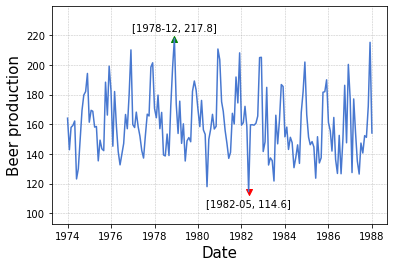

In [22]:
file = '../Example_Data/Time_series/monthly-beer-production-in-austr.csv'
ts = TimeSeries(file)
ts.plot(x_col_name='Month',
        y_col_name=['Monthly beer production'], 
        start_time='1974',
        end_time='1988',
        xlabel='Date',
        ylabel=['Beer production'],
        date_fmt='%Y-%m',
        show_min=True,
        min_annotate=True,
        show_max=True,
        max_annotate=True,
        save_fig=True,
        fig_path="D:/project/Paper-Viz/Images/Time_series/ts_max.png")

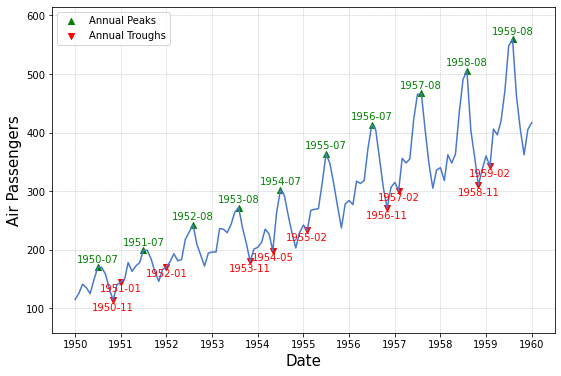

In [23]:
file = '../Example_Data/Time_series/AirPassengers.csv'
ts = TimeSeries(file)
ts.plot(x_col_name='Month',
        y_col_name=['#Passengers'],
        xlabel='Date',
        ylabel=['Air Passengers'],
        start_time='1950',
        end_time='1960', 
        date_fmt='%Y-%m',
        figsize=(9, 6),
        show_peaks=True,
        show_troughs=True,
        peak_annotate=True,
        trough_annotate=True,
        save_fig=True,
        fig_path='D:/project/Paper-Viz/Images/Time_series/ts_peaks.png')

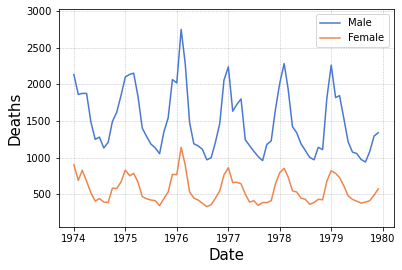

In [24]:
file = '../Example_Data/Time_series/mortality.csv'
ts = TimeSeries(file)
ts.plot(x_col_name='date',
        y_col_name=['mdeaths', 'fdeaths'],
        xlabel='Date',
        ylabel=['Deaths'],
        legend=['Male', 'Female'],
        save_fig=True,
        fig_path='D:/project/Paper-Viz/Images/Time_series/ts_multivariable.png')

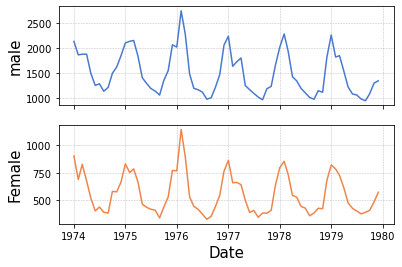

In [25]:
file = '../Example_Data/Time_series/mortality.csv'
ts = TimeSeries(file)
ts.plot(x_col_name='date',
        y_col_name=['mdeaths', 'fdeaths'],
        xlabel='Date',
        ylabel=['male', 'Female'],
        multiple_plot=True,
        save_fig=True,
        fig_path='D:\project\Paper-Viz\Images\Time_series/ts_multiple_plot.png')

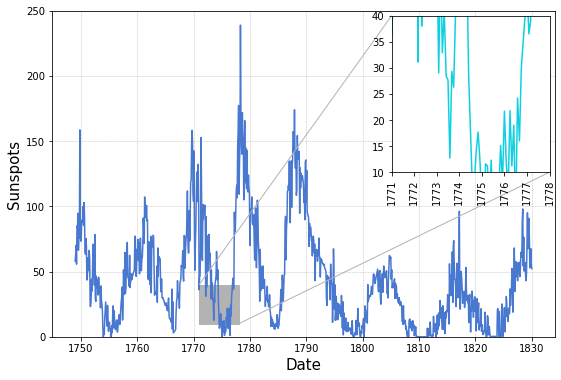

In [26]:
file = '../Example_Data/Time_series/monthly-sunspots.txt'
ts = TimeSeries(file)
ts.plot('Month', ['Sunspots'],
        end_time='1830',
        figsize=(9, 6),
        xlabel='Date',
        ylabel=['Sunspots'],
        zoom_in=True,
        zoom_scale=4,
        x_start=['1771'],
        x_end=['1778'],
        y_start=[10],
        y_end=[40],
        ylim_top=250,
        ylim_bot=0,
        save_fig=True,
        fig_path='D:\project\Paper-Viz\Images\Time_series/ts_zoomin.png')